In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib
import numpy
from matplotlib import pyplot
from scipy import stats
num_of_tropes = 30

In [2]:
# this cell has code partially used from the PicTropes dataset preprocessing by R. H. Garcia Ortega
# - https://github.com/raiben/tropes_open_data

class TropesAndFilms(object):
    FILE_PATH = 'untitled.txt'
    
    def __init__(self):
        self._load_data()

    def _load_data(self):
        self._init_film_dictionary()
        self._init_trope_dictionary()
        self._init_sorted_keys()
        self._init_film_by_poptrope_dictionary()
        self._init_film_by_raretrope_dictionary()

    def _init_film_dictionary(self):
        data_file_path = self._get_data_file_path()
        with open(data_file_path, 'r') as file:
            self.film_dictionary = json.load(file)

    def _get_data_file_path(self):
        script_dir = os.path.dirname('untitled.txt')
        data_file_path = os.path.join(script_dir, self.FILE_PATH)
        return data_file_path

    def _init_trope_dictionary(self):
        self.trope_dictionary = {}
        for film in self.film_dictionary.keys():
            trope_list = self.film_dictionary[film]
            for trope in trope_list:
                if trope not in self.trope_dictionary:
                    self.trope_dictionary[trope] = []
                self.trope_dictionary[trope].append(film)

    def _init_film_by_poptrope_dictionary(self):
        self.film_by_poptrope_dictionary = {}
        for trope in self.trope_dictionary.keys():
            film_list = self.trope_dictionary[trope]
            for film in film_list:
                if film not in self.film_by_poptrope_dictionary:
                    self.film_by_poptrope_dictionary[film] = []
                if len(film_list) > num_of_tropes:
                    self.film_by_poptrope_dictionary[film].append(trope)

    def _init_film_by_raretrope_dictionary(self):
        self.film_by_raretrope_dictionary = {}
        for trope in self.trope_dictionary.keys():
            film_list = self.trope_dictionary[trope]
            for film in film_list:
                if film not in self.film_by_raretrope_dictionary:
                    self.film_by_raretrope_dictionary[film] = []
                if len(film_list) <= num_of_tropes:
                    self.film_by_raretrope_dictionary[film].append(trope)
    
    def _init_sorted_keys(self):
        self.tropes_sorted_by_occurrences = sorted(self.trope_dictionary.keys(), reverse=True,
                                                   key=lambda element: len(self.trope_dictionary[element]))
        self.film_sorted_by_occurrences = sorted(self.film_dictionary.keys(), reverse=True,
                                                 key=lambda element: len(self.film_dictionary[element]))

    def tropes_dictionary_sorted_by_number_of_films(self):
        dictionary = dict()
        for trope in self.tropes_sorted_by_occurrences:
            dictionary[trope] = len(self.trope_dictionary[trope])
        return dictionary

    def films_dictionary_sorted_by_number_of_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_dictionary[film])
        return dictionary
    
    def films_dictionary_sorted_by_popular_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_by_poptrope_dictionary[film])
        return dictionary
    
    def does_film_have_trope(self, film, trope):
        tropes = self.film_by_poptrope_dictionary[film]
        return trope in tropes
    
    def films_dictionary_sorted_by_rare_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_by_raretrope_dictionary[film])
        return dictionary
    
    def trope_observations_by_film(self):
        return [len(values) for values in self.film_dictionary.values()]

    def film_observations_by_trope(self):
        return [len(values) for values in self.trope_dictionary.values()]
        return 0

In [3]:
data = TropesAndFilms()

occ = data.films_dictionary_sorted_by_number_of_tropes()
tropes = data.tropes_dictionary_sorted_by_number_of_films()
pop_tropes = data.films_dictionary_sorted_by_popular_tropes()
r_tropes = data.films_dictionary_sorted_by_rare_tropes()

movies = [i if not (i[-4:]).isnumeric() else i[:-4] for i in occ]
years = ['' if not (i[-4:]).isnumeric() else i[-4:] for i in occ]
tropes_n = [occ[i] for i in occ]
pop_tropes_n = [pop_tropes[i] for i in pop_tropes]
r_tropes_n = [r_tropes[i] for i in r_tropes]

dic = {'movies' : movies, 'tropes_n' : tropes_n,'pop_tropes_n' : pop_tropes_n, 'r_tropes_n' : r_tropes_n}
pop_tr = [i for i in tropes if tropes[i] > num_of_tropes]

for trope in pop_tr:
    lst = []
    for film, year in zip(movies,years):
        lst.append(data.does_film_have_trope(film+year, trope))
    dic[trope] = lst
    
dic['movies'] = [i.lower() for i in movies]
dt = pd.DataFrame(dic)
dt = dt.sort_values(by=['movies'])
dt['id'] = 0
dt.to_csv('new.csv')

In [4]:
dt['movies'].is_unique

False

In [5]:
metadata = pd.read_csv('movies_metadata.csv')
# my_dt = pd.read_csv('new.csv')
# keywords = pd.read_csv('keywords.csv')
credits = pd.read_csv('credits.csv')

metadata.original_title = metadata.original_title.apply(lambda x: ''.join(e for e in x if e.isalnum() or e == "-").lower()) 
metadata.title = metadata.title.apply(lambda x: ''.join(e for e in x if e.isalnum() or e == "-").lower() if type(x) == str else '')

metadata = metadata.drop_duplicates(subset='id',keep='first')

/home/hungrynagini/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
print(metadata.id.is_unique)

True


In [7]:
reduced_metadata = pd.DataFrame(columns = metadata.columns)
movies = [''.join(e for e in i if e.isalnum() or e == "-").lower() for i in movies]
for i in range(len(movies)):
    if movies[i] in metadata.original_title.values or movies[i] in metadata.title.values:
        if years[i]:
            ser = metadata.loc[lambda meta: meta['original_title'] == movies[i]]['release_date']
            for j in ser:
                if years[i] == j[:4]:
                    film = metadata[(metadata['release_date'] == j) & ((metadata['original_title'] == movies[i]))]
                    reduced_metadata = reduced_metadata.append(film)
                    dt.loc[dt.movies == movies[i]+years[i],'id'] = film.id.values[0]
        else:
            film = metadata[metadata['original_title'] == movies[i]]
            if film.shape != (0,24):
                reduced_metadata = reduced_metadata.append(film)
            else:
                film = metadata[metadata['title'] == movies[i]]
                reduced_metadata = reduced_metadata.append(film)
            if film.shape != (0,24):
                for idd in film.id.values:
                    if idd not in dt.id.values:
                        dt.loc[dt.movies == movies[i],'id'] = idd
                        break
print(reduced_metadata.shape)

/home/hungrynagini/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(5642, 24)


In [8]:
reduced_metadata = reduced_metadata.drop_duplicates()
print(reduced_metadata.shape)

(5638, 24)


In [9]:
reduced_metadata = reduced_metadata.merge(dt,on='id')
reduced_metadata.to_csv('new_.csv')

In [24]:
import json
reduced_metadata.belongs_to_collection = metadata.belongs_to_collection.apply(lambda x: 1 if type(x) != float else 0)
def try_load(row):
    try:
        jsonparse = json.loads(row)
        return jsonparse
    except Exception as e:
        return []
companies = {'Orion Pictures': 35,'Fox Searchlight Pictures': 36, 'Hollywood Pictures': 36, 'Amblin Entertainment': 41,
 'Regency Enterprises': 42,'Village Roadshow Pictures': 45,'DreamWorks SKG': 46,'Canal+': 53,'Relativity Media': 
 62,'Miramax Films': 63,'Walt Disney Pictures': 69,'United Artists': 85,'TriStar Pictures': 86, 'Touchstone Pictures': 
 88,'Columbia Pictures Corporation': 100,'New Line Cinema': 107,'Columbia Pictures': 153, 'Metro-Goldwyn-Mayer (MGM)': 
 153,'Twentieth Century Fox Film Corporation': 234,'Paramount Pictures': 292, 'Universal Pictures': 296,
             'Warner Bros.': 343, 'Marvel Studios':29,  'Marvel Enterprises':29, 'Marvel Entertainment':29}

cmp = reduced_metadata.apply(lambda x: [i['name']
                          for i in try_load(x.production_companies.replace("'","\""))] if 
                                                         len(x) > 2 and type(x) != float else 0,axis=1)
reduced_metadata = reduced_metadata.assign(prod_cmp=cmp.values)
for i in companies.keys():
    i_ = reduced_metadata.apply(lambda x: 1
                          if i in x.prod_cmp and len(x) > 0 and type(x) != float else 0,axis=1)
    reduced_metadata = reduced_metadata.assign(i=i_.values)

reduced_metadata = reduced_metadata.drop(["prod_cmp"],axis=1)

c = {'United Kingdom': 767, 'United States of America': 4280, 'Germany': 308, 'Canada': 270, 'China': 42, 
     'Australia': 124, 'France': 337, 'New Zealand': 26, 'Czech Republic': 19, 'South Africa': 20, 'India': 23, 
     'Japan': 168, 'Italy': 154, 'Malta': 2, 'Hong Kong': 66, 'Singapore': 3, 'Indonesia': 2, 'Sweden': 36, 
     'Spain': 63, 'Mexico': 30, 'South Korea': 27, 'Hungary': 9, 'Finland': 9, 'Iceland': 7, 'Austria': 16, 
     'Brazil': 8, 'Belgium': 24, 'Bahamas': 1, 'Taiwan': 10, 'Namibia': 2, 'Serbia': 4, 'Russia': 33, 
     'Morocco': 4, 'Ireland': 38, 'Aruba': 3, 'United Arab Emirates': 7, 'Norway': 14, 'Slovenia': 1, 'Peru': 5, 
     'Romania': 9, 'Tunisia': 2, 'Slovakia': 1, 'Netherlands': 23, 'Denmark': 27, 'Thailand': 7, 'Botswana': 1, 
     'Cameroon': 1, 'Poland': 23, 'Nicaragua': 1, 'Argentina': 10, 'Israel': 11, 'Switzerland': 15, 
     'Luxembourg': 12, 'Turkey': 2, 'Cuba': 1, 'Bulgaria': 3, 'Cyprus': 1, 'Philippines': 5, 'Croatia': 3, 
     'Lithuania': 1, 'Pakistan': 2, 'Algeria': 2, 'Angola': 1, 'Greece': 4, 'Portugal': 4, 'Uruguay': 2, 
     'Malaysia': 1, 'Yugoslavia': 1, 'Soviet Union': 1, 'Paraguay': 1, 'Trinidad and Tobago': 1, 'Iran': 3, 
     'Chile': 2, 'Bosnia and Herzegovina': 1, 'Puerto Rico': 2, 'Kazakhstan': 1, 'Georgia': 2, 'North Korea': 1, 
     'Czechoslovakia': 1, 'Afghanistan': 1, 'Estonia': 1, 'Ecuador': 1, 'Monaco': 1, 'Liechtenstein': 1}

reduced_metadata.countries_points_sum = 0
reduced_metadata.countries_usa = 0
reduced_metadata.countries_rare = 0
col = reduced_metadata.apply(lambda x: 1 if sum([1 if c[i['name']] < 40 else 0 for i in 
     json.loads(x.production_countries.replace("'","\""))]) and len(x) > 2 and type(x) != float else 0, axis=1)
col2 = reduced_metadata.apply(lambda x: 1 if {"iso_3166_1": "US", "name": "United States of America"}
    in json.loads(x.production_countries.replace("'","\"")) and len(x) > 2 and type(x) != float else 0,axis=1)
col3 = reduced_metadata.apply(lambda x: sum([c[i['name']] 
  for i in json.loads(x.production_countries.replace("'","\""))]) if len(x) > 2 and type(x) != float else 0,axis=1)
reduced_metadata = reduced_metadata.assign(countries_rare=col.values,countries_usa=col2.values,
                                           countries_points_sum=col3.values )

In [25]:
reduced_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       ...
       'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie', 'i'],
      dtype='object', length=1813)

In [57]:
genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 
          'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 
          'Documentary', 'Western', 'TV Movie']
# reduced_metadata.genres = metadata.genres.apply(lambda x: [i['name'] 
#                           for i in json.loads(x.replace("'","\""))] if len(x) > 2 and type(x) != float else 0) 
for i in genres:
    reduced_metadata[i] = metadata.genres.apply(lambda x: 1 if i in x and type(x) != float else 0) 
features = reduced_metadata.drop(['id','original_language','tagline','overview','status','production_companies',
                                  'spoken_languages','production_countries','adult','movies','video',
                                  "homepage",'imdb_id','original_title','title','poster_path','genres'],axis=1)
features = features.dropna()
import datetime as dt
features['Date'] = pd.to_datetime(features['release_date'])
features['Date']=features['Date'].map(dt.datetime.toordinal)
features['Date2'] = features['release_date'].apply(lambda x: int(x[-5:-3]+x[-2:]))
features = features.drop(["release_date"],axis=1)
features.Date

0       735444
1       734700
2       734340
3       734248
4       733764
         ...  
4883    734491
4884    734179
4885    733408
4886    722227
4887    733812
Name: Date, Length: 4887, dtype: int64

In [120]:
from sklearn.impute import SimpleImputer

numeric_imputer = SimpleImputer(missing_values = 0, strategy = 'mean')
features[['budget', 'revenue']] = numeric_imputer.fit_transform(features[['budget', 'revenue']])

features['gross_revenue'] = features['revenue']
revenue = features.revenue.astype('float')/features.budget.astype('float')
features['revenue_percent'] = revenue
rating = features.vote_average.astype('float')
popularity = features.popularity.astype('float')
features = features.rename(columns={'ComicBookMoviesDontUseCodenames':"CBMDUC",'WhatHappenedToTheMouse':"WHTTM"})

feat_rat = ['Date','belongs_to_collection','budget','popularity','revenue_percent','runtime','vote_average',
'pop_tropes_n','r_tropes_n', 'Comedy', 'Family', 'Adventure','countries_points_sum','tropes_n','gross_revenue',
'Romance', 'Drama', 'Action', 'Crime', 'Thriller','BittersweetEnding','ShoutOut','Date2','vote_count']

feat_pop = ['Date','belongs_to_collection','budget','popularity','revenue','runtime','vote_average',
'pop_tropes_n','r_tropes_n', 'Comedy','countries_points_sum','tropes_n','Marvel Studios',
'Romance', 'Drama', 'Action', 'Thriller','ManlyTears','CBMDUC','Warner Bros.','gross_revenue','revenue_percent',
            'ShoutOut','Date2','BigBad','BittersweetEnding','Foreshadowing','TechnologyPorn']

feat_rev = ['Date','belongs_to_collection','budget','popularity','revenue','runtime','vote_average','revenue_percent',
'pop_tropes_n','r_tropes_n', 'Comedy', 'Family', 'Adventure','countries_points_sum','tropes_n','MythologyGag',
'Romance', 'Drama', 'Action', 'Crime', 'Thriller','BittersweetEnding','ShoutOut','Date2','Foreshadowing','gross_revenue']

pop_feat = features[feat_pop]
rev_feat = features[feat_rev]
rat_feat = features[feat_rat]

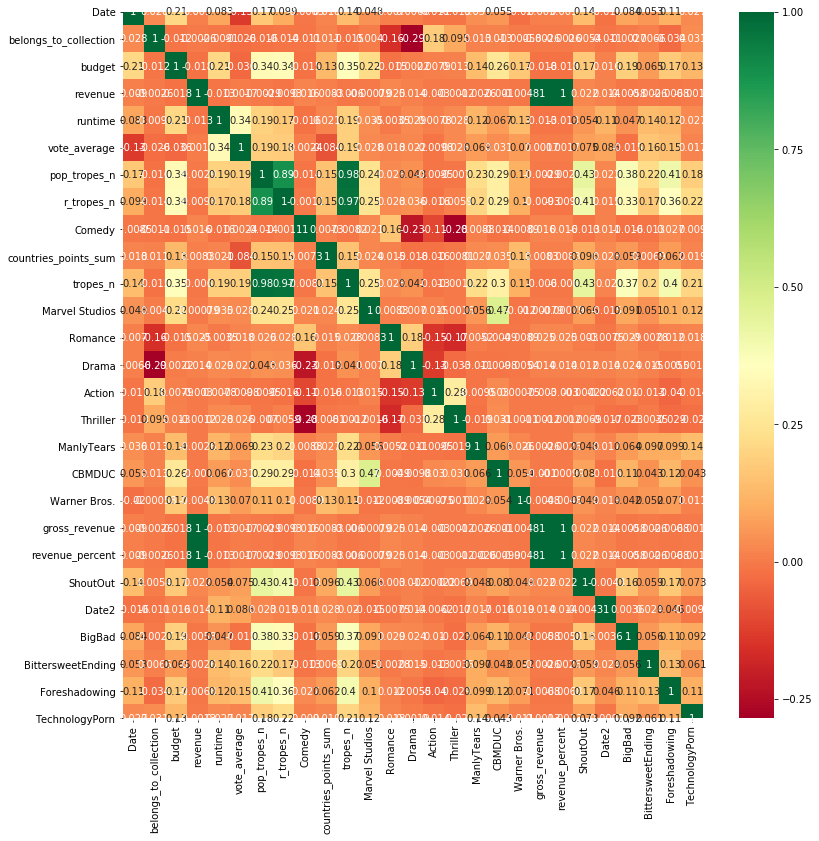

In [121]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
#get correlations of each feature
# for i in [pop_feat, rat_feat, rev_feat]:
i = pop_feat
corrmat = i.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(13,13))
#plot heat map
g=sns.heatmap(i[top_corr_features].corr(),annot=True,cmap="RdYlGn")

count    4.887000e+03
mean     2.302157e+04
std      1.327414e+06
min     -1.189980e-04
25%      1.544739e-31
50%      2.471706e-30
75%      1.979884e-29
max      9.157477e+07
dtype: float64


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[4.90652345e-07 2.36017568e-04 1.11265425e-04 ... 3.99266404e-06
 0.00000000e+00 0.00000000e+00]


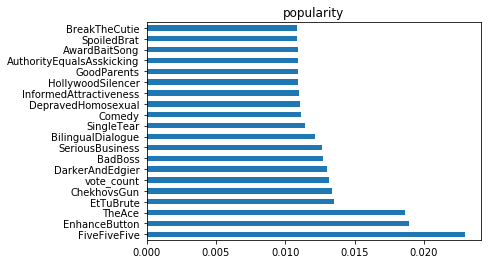

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[2.56403787e-03 1.69463306e-05 1.09523286e-04 ... 1.00810272e-02
 1.15581832e-01 1.98327636e-01]


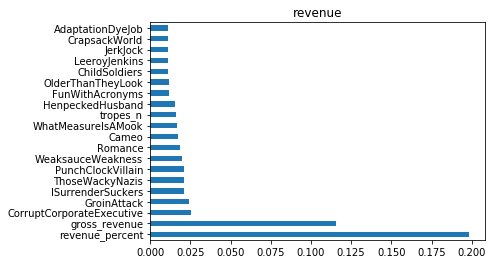

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[3.88044544e-03 6.33256969e-03 9.91176868e-03 ... 8.66623831e-03
 1.10553204e-04 8.65455910e-05]


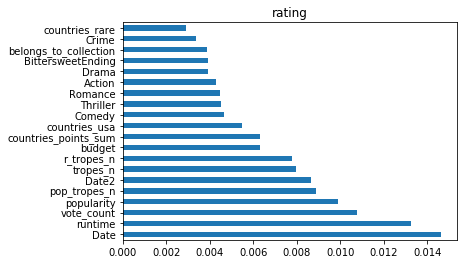

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.08220124 0.02849441 0.06846369 0.06218301 0.10562551 0.0888423
 0.08207702 0.03364158 0.04806441 0.06561941 0.02207616 0.0152732
 0.03041192 0.01863587 0.01272018 0.0017617  0.0194936  0.0294704
 0.         0.         0.04531082 0.06232005 0.00925467 0.03173589
 0.02884152 0.00748144]


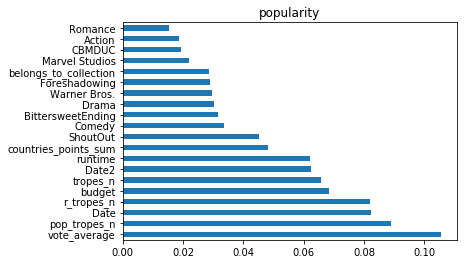

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[6.02756526e-03 3.91815857e-04 1.71988190e-03 7.91716323e-03
 4.90955035e-03 4.72089171e-01 1.16177239e-02 3.74465758e-03
 9.50043459e-04 8.70030289e-05 2.17072418e-03 4.46264785e-03
 7.49786128e-03 1.32465318e-06 2.78709841e-03 7.92491144e-05
 8.31300444e-03 2.12803349e-03 2.63662040e-04 3.40044965e-04
 5.72063061e-04 1.83539872e-02 1.05157059e-04 4.43470567e-01]


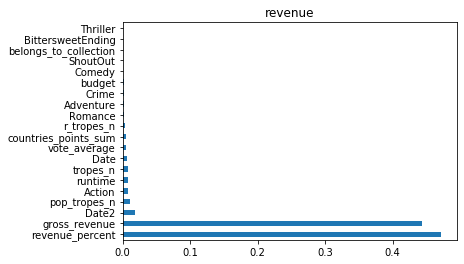

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09607167 0.02148598 0.0630175  0.08510228 0.00097995 0.09079473
 0.0728917  0.07045902 0.02630823 0.01510115 0.01696245 0.0532878
 0.07290439 0.00128363 0.02064191 0.03130622 0.01956599 0.01804137
 0.02153024 0.01171442 0.01955724 0.07903231 0.09195982]


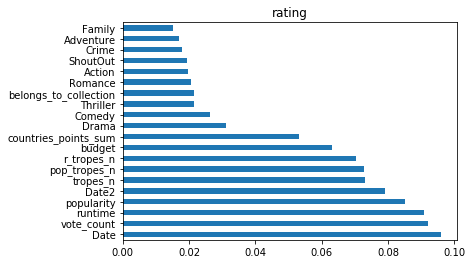

In [122]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
print(revenue.describe())
popularity = popularity.apply(lambda x: 0 if x < 60 else 1 if x < 120 else 2)
revenue = revenue.apply(lambda x: 0 if x < 0.9 else 1 if x < 2.2 else 2)
rating = pd.cut(rating, bins=10, labels=np.arange(10), right=False)

for i in [[features,features,features],[pop_feat, rev_feat, rat_feat]]:
    
    x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
    x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)

    for x,y,z,bins_ in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating], 
                 ['popularity', 'revenue', 'rating'],[20,15,10]):
#         y = pd.cut(y, bins=bins_, labels=np.arange(bins_), right=False)
        model = ExtraTreesClassifier()
        model.fit(x,y)
        print(model.feature_importances_)
        feat_importances = pd.Series(model.feature_importances_, index=x.columns)
        feat_importances.nlargest(20).plot(kind='barh')
        plt.title(z)
        plt.show()

In [124]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

model = LogisticRegression()

for i,what in zip([[features,features,features],[pop_feat, rev_feat, rat_feat]],
                  ['features including tropes','features without separate tropes']):
    print(what)
    x_for_popularity = i[0].drop(['popularity','gross_revenue'],axis=1)
    x_for_revenue = i[1].drop(['gross_revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)
    for x,y in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating]):
#         print(pd.cut(y,bins= bins_))
        x = RobustScaler().fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        model.fit(x_train, y_train)

        acc_trained = model.score(x_train, y_train)
        print("Training accuracy: {}".format(acc_trained))

        predicted = model.predict(x_test)

        acc_test = accuracy_score(y_test, predicted)
        print("Testing accuracy:  {}\n".format(acc_test))

        f_score = f1_score(y_test, predicted, average='micro')
        print("f1:", f_score)
        print('Confusion Matrix - Training Dataset')
        print(pd.crosstab(y_test, predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("\n",cross_val_score(LogisticRegression(), x, y, cv=3))
        

features including tropes


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training accuracy: 0.6331704337202199
Testing accuracy:  0.6298822070675759

f1: 0.6298822070675759
Confusion Matrix - Training Dataset
Predicted     0    1   All
True                      
0          1014  594  1608
1             1    2     3
2             2    0     2
All        1017  596  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/


 [0.54662577 0.63781461 0.66707617]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy: 0.6560781918142944
Testing accuracy:  0.6751394916305021

f1: 0.6751394916305021
Confusion Matrix - Training Dataset
Predicted     0    2   All
True                      
0          1087  524  1611
2             0    2     2
All        1087  526  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 [0.59607121 0.6635973  0.67833026]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training accuracy: 0.14844227244960292
Testing accuracy:  0.14693118412895226

f1: 0.14693118412895226
Confusion Matrix - Training Dataset
Predicted  5    6    8    9   All
True                             
0          0    4    0    0     4
1          0    6    0    1     7
2          0   11    3    4    18
3          0    8    2    3    13
4          1   38   24   22    85
5          1   74   62  114   251
6          4  187  171  271   633
7          0  154  172  154   480
8          0   43   49   28   120
9          0    2    0    0     2
All        6  527  483  597  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/


 [0.18516248 0.21853898 0.2335587 ]
features without separate tropes
Training accuracy: 0.6331704337202199
Testing accuracy:  0.6298822070675759

f1: 0.6298822070675759
Confusion Matrix - Training Dataset


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Predicted     0    1   All
True                      
0          1014  594  1608
1             1    2     3
2             2    0     2
All        1017  596  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/


 [0.54417178 0.63781461 0.66769042]
Training accuracy: 0.6557727550397068
Testing accuracy:  0.6751394916305021

f1: 0.6751394916305021
Confusion Matrix - Training Dataset
Predicted     0    2   All
True                      
0          1087  524  1611
2             0    2     2
All        1087  526  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will 


 [0.59484346 0.6635973  0.68324125]
Training accuracy: 0.1487477092241906
Testing accuracy:  0.14507129572225666

f1: 0.14507129572225666
Confusion Matrix - Training Dataset
Predicted  1   5    6    8    9   All
True                                 
0          0   0    4    0    0     4
1          0   0    6    0    1     7
2          0   0   11    3    4    18
3          0   0    8    2    3    13
4          0   3   36   24   22    85
5          0   0   74   62  115   251
6          1   5  185  171  271   633
7          0   2  152  172  154   480
8          0   0   43   49   28   120
9          0   0    2    0    0     2
All        1  10  521  483  598  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/


 [0.18025751 0.22222222 0.21942225]
